In [31]:
! ls

1_eda_preprocess.ipynb
2_optuna.ipynb
3_botorch_lr.ipynb
3_botorch_nn.ipynb
3_botorch_nn_v2.ipynb
3_botorch_rf.ipynb
bank.csv
botorch_lr_multi_objective_all_trials.png
botorch_lr_multi_objective_coefficients.png
botorch_lr_multi_objective_parameter_analysis.png
botorch_lr_multi_objective_parameter_space.png
botorch_lr_multi_objective_pareto_frontier.png
diffusion_animation.py
lr
nn
pareto_results.csv
processed_bank_marketing.csv
requirements.txt


In [32]:
import torch
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt



# BoTorch imports
import botorch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.optim import optimize_acqf
from botorch.acquisition.multi_objective import ExpectedHypervolumeImprovement
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
from botorch.exceptions.warnings import InputDataWarning
from gpytorch.mlls import ExactMarginalLogLikelihood
import torch.optim as optim

In [33]:
print(f"Using BoTorch version: {botorch.__version__}")

Using BoTorch version: 0.14.0


# Load and Prepare Data

In [34]:
# Loading the preprocessed CSV
df = pd.read_csv("processed_bank_marketing.csv")

#  Ensuring no missing data
df = df.dropna()

# Extract features, labels, and protected group
X = df.drop(columns=["deposit"])
y = df["deposit"].values
protected_attr = df["marital"].values  # 0, 1, 2 -> single, married, divorced ( values selected based on the observation while doing EDA )


# Ensure all columns are numeric (if necessary)
X = pd.get_dummies(X, drop_first=True)

# Preprocess the data (standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, m_train, m_test = train_test_split(
    X_scaled, y, protected_attr, test_size=0.2, random_state=42
)

In [35]:
# Define fairness metric (max-min demographic parity across marital groups)
def demographic_parity_diff(y_pred_proba, protected_group):
    """
    Calculate demographic parity difference based on predicted probabilities
    """
    group_probs = [
        y_pred_proba[protected_group == g].mean()
        for g in np.unique(protected_group)
    ]
    return max(group_probs) - min(group_probs)

# Function to train and evaluate logistic regression
def train_and_evaluate_lr(params):
    # Extract parameters
    C = params[0].item()  # Regularization strength (inverse)
    penalty_type = 'l1' if params[1].item() < 0.5 else 'l2'  # 0 = L1, 1 = L2
    class_weight_param = params[2].item()  # 0 = None, 1 = balanced
    solver = 'liblinear'  # Compatible with both L1 and L2 penalties
    
    # Convert class_weight_param to appropriate value
    class_weight = 'balanced' if class_weight_param >= 0.5 else None
    
    # Print the parameters
    print(f"Training LR with: C={C:.6f}, penalty={penalty_type}, class_weight={class_weight}")
    
    # Initialize and train the model
    lr = LogisticRegression(
        C=C,
        penalty=penalty_type,
        class_weight=class_weight,
        solver=solver,
        max_iter=1000,
        random_state=42
    )
    
    # Train the model
    lr.fit(X_train, y_train)
    
    # Make predictions
    y_pred = lr.predict(X_test)
    y_pred_proba = lr.predict_proba(X_test)[:, 1]  # Probability of positive class
    
    # Calculate accuracy and fairness
    acc = accuracy_score(y_test, y_pred)
    fairness = demographic_parity_diff(y_pred_proba, m_test)
    
    print(f"  Results: Accuracy = {acc:.4f}, Fairness = {fairness:.4f}")
    
    # For MOO, we return a tensor with two objectives:
    # 1. Accuracy (to maximize)
    # 2. Negative fairness (to maximize, equivalent to minimizing fairness metric)
    return torch.tensor([acc, -fairness], dtype=torch.float32)


In [36]:
# Manually fit GP model
def manual_fit_gp(model, train_x, train_y, training_iter=100, lr=0.1):
    """Manually fit a GP model using Adam optimizer"""
    # Define loss and optimizer
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    
    return model

# Define parameter bounds for BoTorch
bounds = torch.tensor([
    [1e-4, 0.0, 0.0],   # lower bounds: C, penalty_type, class_weight
    [10.0, 1.0, 1.0]    # upper bounds: C, penalty_type, class_weight
], dtype=torch.float32)

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=InputDataWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

# Generate initial points with multi-objective evaluation
def generate_initial_points(n_samples=10):
    print(f"Generating {n_samples} initial random points...")
    # Generate random points within bounds
    X_init = torch.rand(n_samples, 3)  # 3 parameters to optimize
    
    # Scale to the parameter ranges
    X_init = bounds[0] + X_init * (bounds[1] - bounds[0])
    
    # Evaluate each point
    Y_init = torch.zeros(n_samples, 2)  # 2 objectives: accuracy and fairness
    
    for i in range(n_samples):
        results = train_and_evaluate_lr(X_init[i])
        Y_init[i] = results
        print(f"  Trial {i+1}: acc={results[0]:.4f}, fairness={-results[1]:.4f}")
        
    return X_init, Y_init

# Run Multi-Objective Bayesian optimization with BoTorch
def run_botorch_multi_objective_optimization(n_iterations=400):
    print("Initializing with random trials...")
    X_train, Y_train = generate_initial_points(n_samples=100)
    
    # Store all results
    all_X = X_train.clone()
    all_Y = Y_train.clone()
    
    # Set up reference point for hypervolume calculation
    # This represents the minimum acceptable performance
    # [min_accuracy, min_negative_fairness]
    ref_point = torch.tensor([0.5, -0.3])  # 50% accuracy, 0.3 fairness difference
    
    print(f"Starting optimization for {n_iterations} iterations...")
    
    for i in range(n_iterations):
        try:
            # 1. Fit a multi-output GP model
            # We need a separate GP for each objective
            models = []
            for j in range(Y_train.shape[1]):
                # Extract the j-th objective
                gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
                mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
                
                # Manual fitting
                gp = manual_fit_gp(gp, X_train, Y_train[:, j:j+1])
                models.append(gp)
            
            # Combine models into a ModelListGP
            model = ModelListGP(*models)
            
            # 2. Get the current Pareto frontier
            pareto_Y = Y_train
            
            # Create a partitioning of the non-dominated space
            partitioning = NondominatedPartitioning(ref_point=ref_point, Y=pareto_Y)
            
            # 3. Define the acquisition function (Expected Hypervolume Improvement)
            # This seeks to maximize the hypervolume of the Pareto frontier
            acq_func = ExpectedHypervolumeImprovement(
                model=model,
                ref_point=ref_point,
                partitioning=partitioning,
                objective=IdentityMCMultiOutputObjective()
            )
            
            # 4. Optimize the acquisition function
            candidate, _ = optimize_acqf(
                acq_function=acq_func,
                bounds=bounds,
                q=1,
                num_restarts=10,
                raw_samples=64
            )
            
        except Exception as e:
            print(f"Error in BoTorch optimization: {e}")
            print("Falling back to random sampling...")
            
            # Random sampling as fallback
            candidate = bounds[0] + torch.rand(1, 3) * (bounds[1] - bounds[0])
        
        # 5. Evaluate the new candidate
        print(f"\nIteration {i+1}/{n_iterations}:")
        penalty_type = 'l1' if candidate[0, 1].item() < 0.5 else 'l2'
        class_weight = 'balanced' if candidate[0, 2].item() >= 0.5 else 'None'
        print(f"Candidate: C={candidate[0, 0].item():.6f}, penalty={penalty_type}, class_weight={class_weight}")
        
        results = train_and_evaluate_lr(candidate[0])
        
        # 6. Update training data
        X_train = torch.cat([X_train, candidate])
        Y_train = torch.cat([Y_train, results.unsqueeze(0)])
        
        # 7. Store all results
        all_X = torch.cat([all_X, candidate])
        all_Y = torch.cat([all_Y, results.unsqueeze(0)])
        
    return all_X, all_Y

#  Run optimization
print("Starting Multi-Objective BoTorch optimization for Logistic Regression...")
all_X, all_Y = run_botorch_multi_objective_optimization(n_iterations=3000)

# Extract results
accuracies = all_Y[:, 0].numpy()
fairness_values = -all_Y[:, 1].numpy()  # Convert back to positive values

Starting Multi-Objective BoTorch optimization for Logistic Regression...
Initializing with random trials...
Generating 100 initial random points...
Training LR with: C=6.816591, penalty=l2, class_weight=None


  Results: Accuracy = 0.7900, Fairness = 0.0808
  Trial 1: acc=0.7900, fairness=0.0808
Training LR with: C=2.167135, penalty=l2, class_weight=None
  Results: Accuracy = 0.7900, Fairness = 0.0807
  Trial 2: acc=0.7900, fairness=0.0807
Training LR with: C=3.070950, penalty=l2, class_weight=None
  Results: Accuracy = 0.7900, Fairness = 0.0807
  Trial 3: acc=0.7900, fairness=0.0807
Training LR with: C=3.478825, penalty=l2, class_weight=None
  Results: Accuracy = 0.7900, Fairness = 0.0807
  Trial 4: acc=0.7900, fairness=0.0807
Training LR with: C=8.495006, penalty=l2, class_weight=balanced
  Results: Accuracy = 0.7940, Fairness = 0.0813
  Trial 5: acc=0.7940, fairness=0.0813
Training LR with: C=7.651455, penalty=l1, class_weight=None
  Results: Accuracy = 0.7900, Fairness = 0.0807
  Trial 6: acc=0.7900, fairness=0.0807
Training LR with: C=4.728368, penalty=l2, class_weight=None
  Results: Accuracy = 0.7900, Fairness = 0.0807
  Trial 7: acc=0.7900, fairness=0.0807
Training LR with: C=8.63280

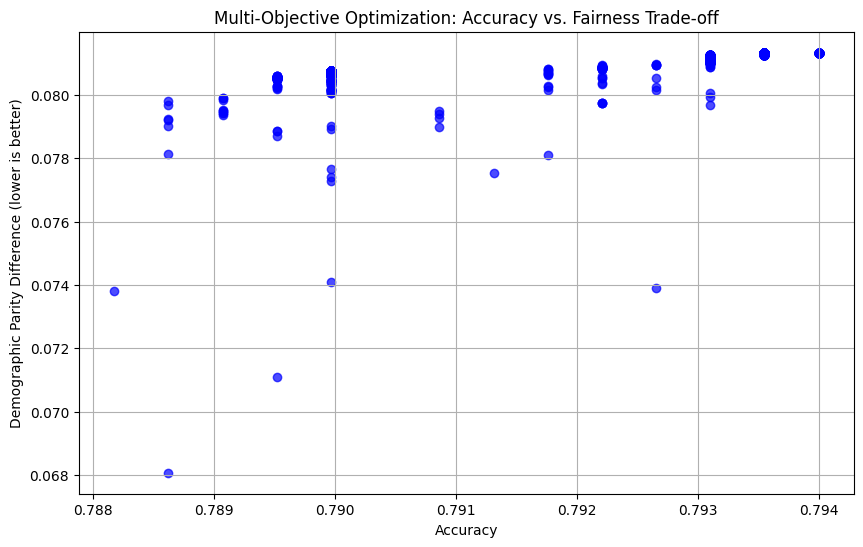


Pareto-Optimal Logistic Regression Configurations:
1. C=0.015925, penalty=l1, class_weight=None, acc=0.7886, fairness=0.0681
2. C=0.021252, penalty=l1, class_weight=None, acc=0.7895, fairness=0.0711
3. C=0.027576, penalty=l1, class_weight=balanced, acc=0.7927, fairness=0.0739
4. C=0.035778, penalty=l2, class_weight=balanced, acc=0.7931, fairness=0.0797
5. C=0.803282, penalty=l2, class_weight=balanced, acc=0.7936, fairness=0.0813
6. C=8.428504, penalty=l2, class_weight=balanced, acc=0.7940, fairness=0.0813
7. C=8.427192, penalty=l2, class_weight=balanced, acc=0.7940, fairness=0.0813


In [37]:
# 14. Plot the results (All trials)
plt.figure(figsize=(10, 6))
plt.scatter(accuracies, fairness_values, c="blue", alpha=0.7)
plt.xlabel("Accuracy")
plt.ylabel("Demographic Parity Difference (lower is better)")
plt.title("Multi-Objective Optimization: Accuracy vs. Fairness Trade-off")
plt.grid(True)
plt.savefig("botorch_lr_multi_objective_all_trials.png")
plt.show()

# 15. Find and visualize the Pareto frontier
# Helper function to determine if a point is Pareto-optimal
def is_pareto_optimal(accuracies, fairness_values, idx):
    # For each candidate solution
    for i in range(len(accuracies)):
        if i != idx:  # Don't compare with itself
            # If another solution has better accuracy and better (lower) fairness
            if accuracies[i] >= accuracies[idx] and fairness_values[i] <= fairness_values[idx] and (
                accuracies[i] > accuracies[idx] or fairness_values[i] < fairness_values[idx]
            ):
                return False  # Not Pareto-optimal
    return True  # No better solution exists

# Find Pareto-optimal points
pareto_optimal = [
    is_pareto_optimal(accuracies, fairness_values, i)
    for i in range(len(accuracies))
]

# Extract Pareto-optimal solutions
pareto_accuracies = accuracies[pareto_optimal]
pareto_fairness = fairness_values[pareto_optimal]
pareto_indices = np.where(pareto_optimal)[0]

# Sort by accuracy for connecting the Pareto frontier
pareto_sort_idx = np.argsort(pareto_accuracies)
pareto_accuracies = pareto_accuracies[pareto_sort_idx]
pareto_fairness = pareto_fairness[pareto_sort_idx]
pareto_indices = pareto_indices[pareto_sort_idx]

# Extract parameters for Pareto-optimal solutions
pareto_params = all_X[pareto_indices].numpy()

# 16. Print Pareto-optimal parameter settings
print("\nPareto-Optimal Logistic Regression Configurations:")
for i in range(len(pareto_indices)):
    idx = pareto_indices[i]
    C_val = all_X[idx, 0].item()
    penalty_type = 'l1' if all_X[idx, 1].item() < 0.5 else 'l2'
    class_weight = 'balanced' if all_X[idx, 2].item() >= 0.5 else 'None'
    
    params = {
        "C": C_val,
        "penalty": penalty_type,
        "class_weight": class_weight
    }
    print(f"{i+1}. C={params['C']:.6f}, penalty={params['penalty']}, class_weight={params['class_weight']}, "
        f"acc={accuracies[idx]:.4f}, fairness={fairness_values[idx]:.4f}")


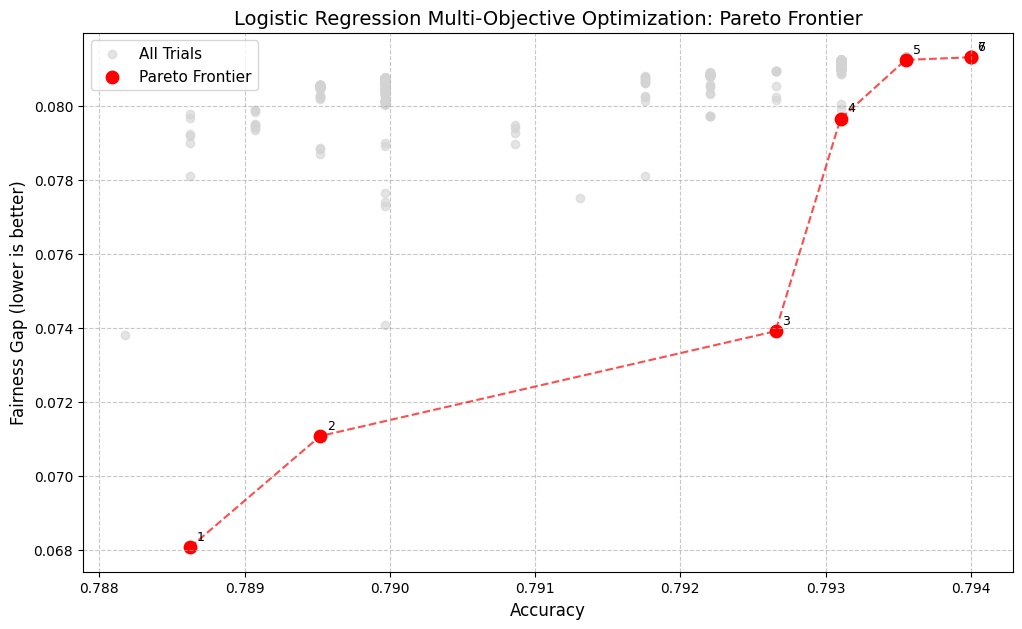

In [38]:
# 17. Visualize the Pareto frontier
plt.figure(figsize=(12, 7))
plt.scatter(accuracies, fairness_values, color="lightgray", alpha=0.6, label="All Trials")
plt.scatter(pareto_accuracies, pareto_fairness, color="red", s=80, label="Pareto Frontier")
plt.plot(pareto_accuracies, pareto_fairness, 'r--', alpha=0.7)  # Connect Pareto points

# Add annotations
for i, (x, y) in enumerate(zip(pareto_accuracies, pareto_fairness)):
    plt.annotate(f"{i+1}", (x, y), textcoords="offset points", xytext=(5, 5), fontsize=9)

# Add detailed formatting
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Fairness Gap (lower is better)", fontsize=12)
plt.title("Logistic Regression Multi-Objective Optimization: Pareto Frontier", fontsize=14)
plt.legend(fontsize=11)

plt.savefig("botorch_lr_multi_objective_pareto_frontier.png")
plt.show()

In [42]:
import csv
with open('pareto_results.csv', 'a', newline='') as f:
    writer = csv.writer(f)
    for i in range(len(pareto_indices)):
        idx = pareto_indices[i]
        writer.writerow([
            'Botorch', 'LR', 
            accuracies[idx], 
            fairness_values[idx],
            str(params)  # params already defined in your print statement
        ])

# Additional Visualization for further Insights

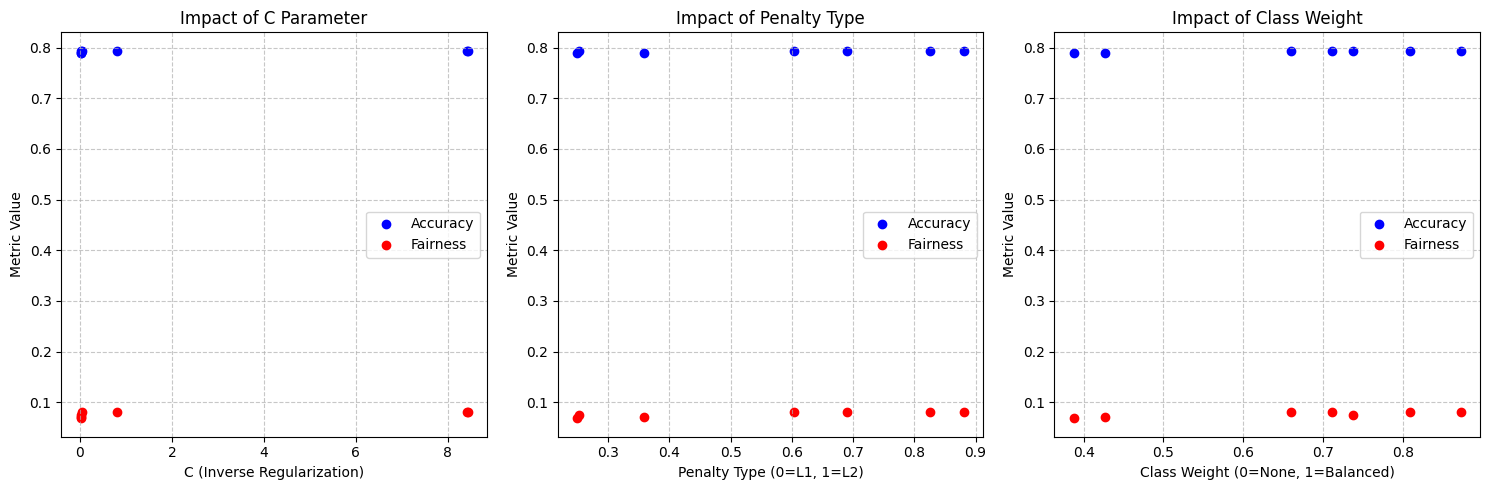

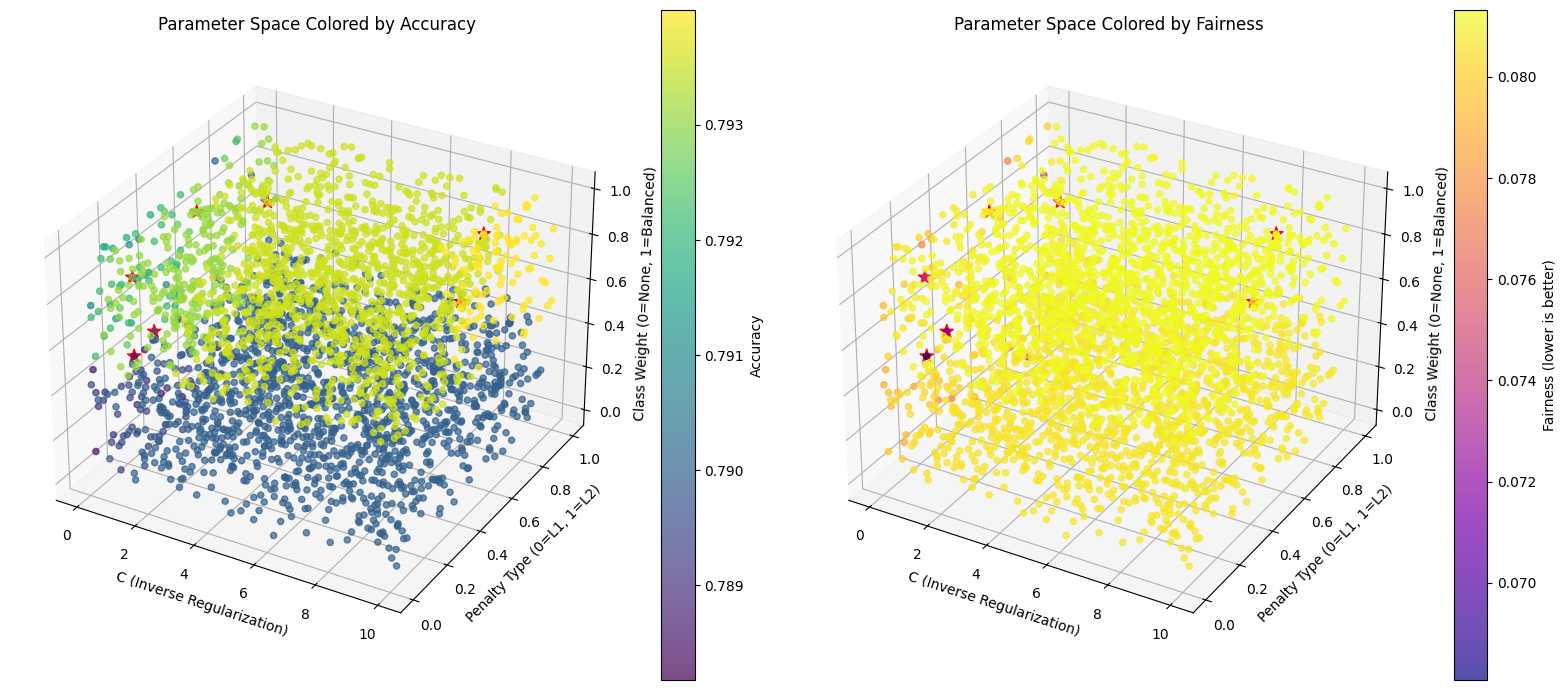


Best Accuracy Model:
Parameters: C=8.495006, penalty=l2, class_weight=balanced
Performance: Accuracy = 0.7940, Fairness Gap = 0.0813

Most Fair Model:
Parameters: C=0.015925, penalty=l1, class_weight=None
Performance: Accuracy = 0.7886, Fairness Gap = 0.0681

Compromise Model (balancing accuracy and fairness):
Parameters: C=0.027576, penalty=l1, class_weight=balanced
Performance: Accuracy = 0.7927, Fairness Gap = 0.0739


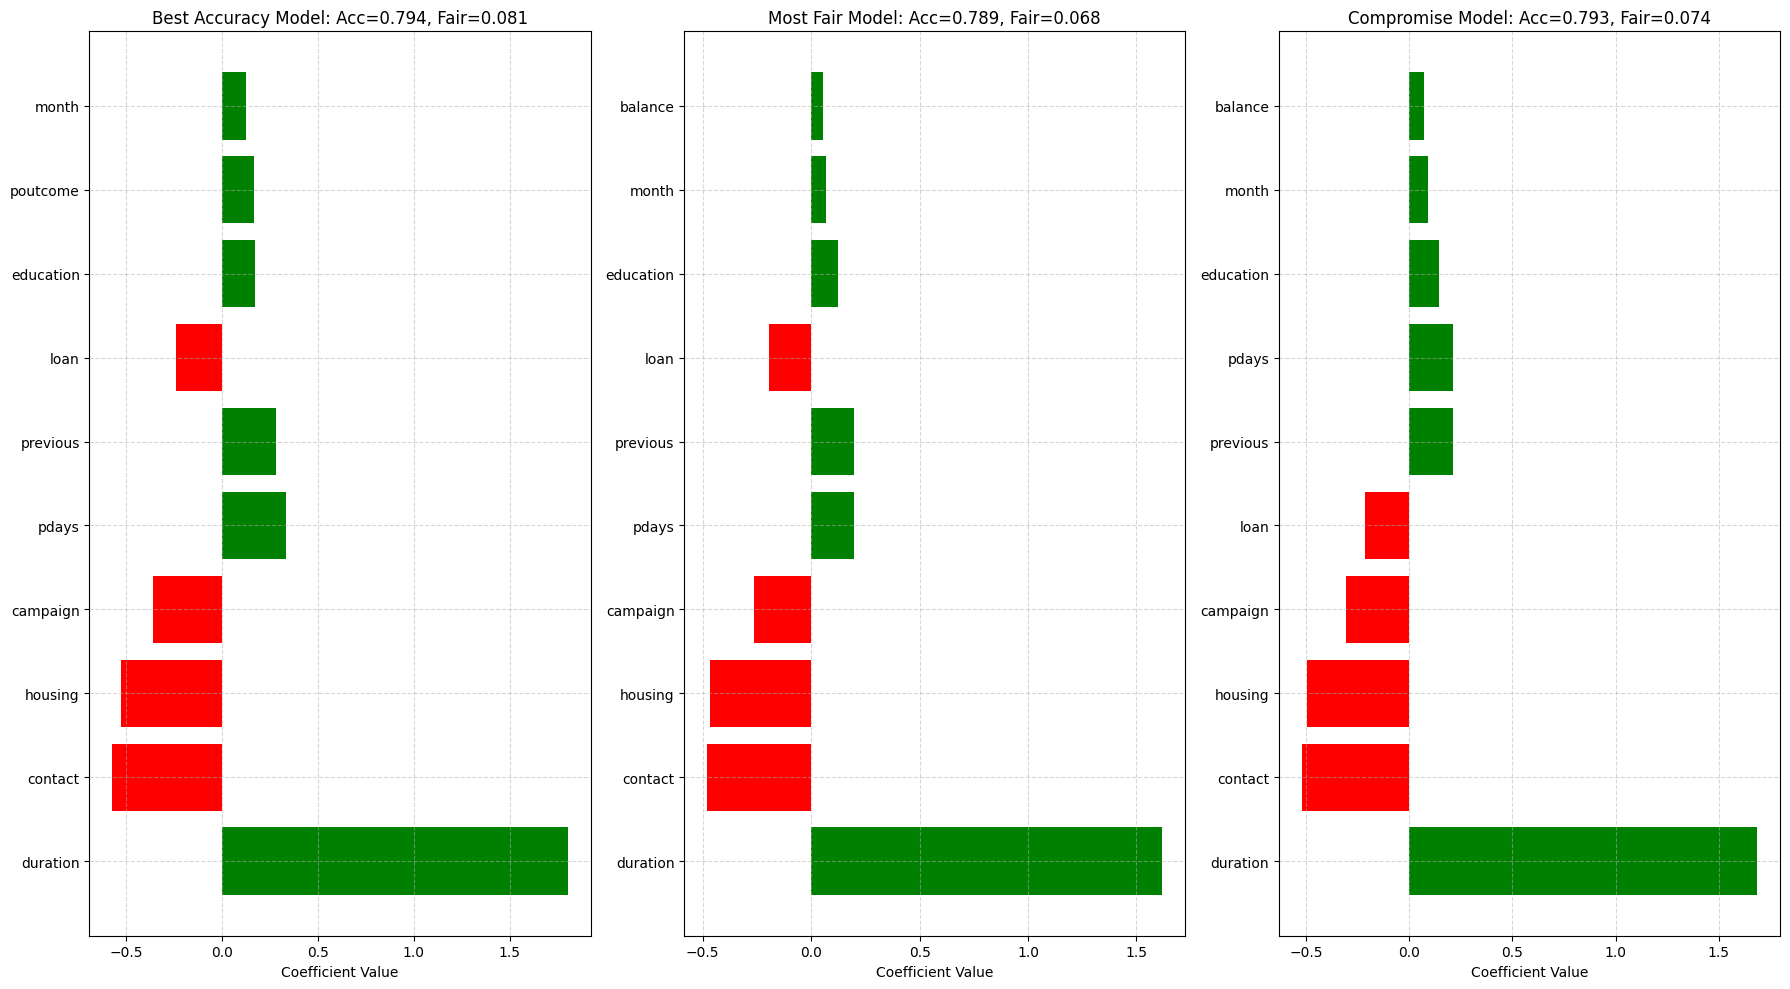

In [40]:
# A. Parameter analysis for Pareto-optimal solutions - Scatter plots for parameters
plt.figure(figsize=(15, 5))

# C vs accuracy and fairness
plt.subplot(1, 3, 1)
plt.scatter(pareto_params[:, 0], pareto_accuracies, label='Accuracy', color='blue')
plt.scatter(pareto_params[:, 0], pareto_fairness, label='Fairness', color='red')
plt.xlabel('C (Inverse Regularization)')
plt.ylabel('Metric Value')
plt.title('Impact of C Parameter')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Penalty type vs accuracy and fairness
plt.subplot(1, 3, 2)
plt.scatter(pareto_params[:, 1], pareto_accuracies, label='Accuracy', color='blue')
plt.scatter(pareto_params[:, 1], pareto_fairness, label='Fairness', color='red')
plt.xlabel('Penalty Type (0=L1, 1=L2)')
plt.ylabel('Metric Value')
plt.title('Impact of Penalty Type')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Class weight vs accuracy and fairness
plt.subplot(1, 3, 3)
plt.scatter(pareto_params[:, 2], pareto_accuracies, label='Accuracy', color='blue')
plt.scatter(pareto_params[:, 2], pareto_fairness, label='Fairness', color='red')
plt.xlabel('Class Weight (0=None, 1=Balanced)')
plt.ylabel('Metric Value')
plt.title('Impact of Class Weight')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("botorch_lr_multi_objective_parameter_analysis.png")
plt.show()

# B. 3D visualization of the parameter space
from mpl_toolkits.mplot3d import Axes3D

# Create a figure with two subplots
fig = plt.figure(figsize=(16, 7))

# Plot 1: C vs Penalty Type, colored by accuracy
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(
    all_X[:, 0].numpy(),  # C
    all_X[:, 1].numpy(),  # Penalty Type
    all_X[:, 2].numpy(),  # Class Weight
    c=accuracies,
    cmap='viridis',
    alpha=0.7
)
ax1.set_xlabel('C (Inverse Regularization)')
ax1.set_ylabel('Penalty Type (0=L1, 1=L2)')
ax1.set_zlabel('Class Weight (0=None, 1=Balanced)')
plt.colorbar(scatter1, ax=ax1, label='Accuracy')
ax1.set_title('Parameter Space Colored by Accuracy')

# Highlight Pareto-optimal points
ax1.scatter(
    pareto_params[:, 0],
    pareto_params[:, 1],
    pareto_params[:, 2],
    color='red',
    s=100,
    alpha=1.0,
    marker='*'
)

# Plot 2: C vs Penalty Type, colored by fairness
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(
    all_X[:, 0].numpy(),  # C
    all_X[:, 1].numpy(),  # Penalty Type
    all_X[:, 2].numpy(),  # Class Weight
    c=fairness_values,
    cmap='plasma',
    alpha=0.7
)
ax2.set_xlabel('C (Inverse Regularization)')
ax2.set_ylabel('Penalty Type (0=L1, 1=L2)')
ax2.set_zlabel('Class Weight (0=None, 1=Balanced)')
plt.colorbar(scatter2, ax=ax2, label='Fairness (lower is better)')
ax2.set_title('Parameter Space Colored by Fairness')

# Highlight Pareto-optimal points
ax2.scatter(
    pareto_params[:, 0],
    pareto_params[:, 1],
    pareto_params[:, 2],
    color='red',
    s=100,
    alpha=1.0,
    marker='*'
)

plt.tight_layout()
plt.savefig("botorch_lr_multi_objective_parameter_space.png")
plt.show()

# 19. Final analysis - compare the best accuracy model with the most fair model
best_acc_idx = np.argmax(accuracies)
best_fair_idx = np.argmin(fairness_values)

# Function to get parameter descriptions
def get_param_desc(idx):
    C_val = all_X[idx, 0].item()
    penalty_type = 'l1' if all_X[idx, 1].item() < 0.5 else 'l2'
    class_weight = 'balanced' if all_X[idx, 2].item() >= 0.5 else 'None'
    return C_val, penalty_type, class_weight

print("\nBest Accuracy Model:")
C, penalty, weight = get_param_desc(best_acc_idx)
print(f"Parameters: C={C:.6f}, penalty={penalty}, class_weight={weight}")
print(f"Performance: Accuracy = {accuracies[best_acc_idx]:.4f}, Fairness Gap = {fairness_values[best_acc_idx]:.4f}")

print("\nMost Fair Model:")
C, penalty, weight = get_param_desc(best_fair_idx)
print(f"Parameters: C={C:.6f}, penalty={penalty}, class_weight={weight}")
print(f"Performance: Accuracy = {accuracies[best_fair_idx]:.4f}, Fairness Gap = {fairness_values[best_fair_idx]:.4f}")

# Calculate compromise solution (closest to ideal point on the Pareto frontier)
# Normalize objectives to [0,1] range
normalized_acc = (pareto_accuracies - np.min(accuracies)) / (np.max(accuracies) - np.min(accuracies))
normalized_fair = (pareto_fairness - np.min(fairness_values)) / (np.max(fairness_values) - np.min(fairness_values))

# Calculate distance to ideal point (1, 0) - max accuracy, min fairness gap
distances = np.sqrt((1 - normalized_acc)**2 + normalized_fair**2)
compromise_idx = np.argmin(distances)
compromise_real_idx = pareto_indices[compromise_idx]

print("\nCompromise Model (balancing accuracy and fairness):")
C, penalty, weight = get_param_desc(compromise_real_idx)
print(f"Parameters: C={C:.6f}, penalty={penalty}, class_weight={weight}")
print(f"Performance: Accuracy = {accuracies[compromise_real_idx]:.4f}, Fairness Gap = {fairness_values[compromise_real_idx]:.4f}")

# 20. Train final models and check feature coefficients
# Train models using the three configurations identified above (best accuracy, best fairness, compromise)
models_to_analyze = [best_acc_idx, best_fair_idx, compromise_real_idx]
model_names = ["Best Accuracy", "Most Fair", "Compromise"]

# Get feature names
feature_names = list(pd.get_dummies(X, drop_first=True).columns)

plt.figure(figsize=(18, 10))

for i, (idx, name) in enumerate(zip(models_to_analyze, model_names)):
    # Extract parameters
    C_val = all_X[idx, 0].item()
    penalty_type = 'l1' if all_X[idx, 1].item() < 0.5 else 'l2'
    class_weight = 'balanced' if all_X[idx, 2].item() >= 0.5 else 'None'
    
    # Train the model with these parameters
    lr = LogisticRegression(
        C=C_val,
        penalty=penalty_type,
        class_weight=class_weight if class_weight != 'None' else None,
        solver='liblinear',
        max_iter=1000,
        random_state=42
    )
    lr.fit(X_train, y_train)
    
    # Get coefficients
    coefficients = lr.coef_[0]
    
    # Create a DataFrame for easier sorting
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })
    
    # Sort by absolute coefficient value
    coef_df['Abs_Coef'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coef', ascending=False).head(10)
    
    # Plot
    plt.subplot(1, 3, i+1)
    plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=['red' if x < 0 else 'green' for x in coef_df['Coefficient']])
    plt.xlabel('Coefficient Value')
    plt.title(f'{name} Model: Acc={accuracies[idx]:.3f}, Fair={fairness_values[idx]:.3f}')
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("botorch_lr_multi_objective_coefficients.png")
plt.show()